In [66]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import copy
import scipy.optimize as optimize

from mytest import child_model
import NPL
from Solve_NFXP import solve_NFXP
import estimate_NFXP as estimate



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
model = child_model()

In [68]:
solver = solve_NFXP()
ev,pk = solver.poly(model.bellman, beta = model.beta, output=2)

# data
data = model.sim_data(pk)
samplesize = data.shape[0]
print(pk, ev)
data

[0.52996405 0.52996405 0.52996405 0.52996405 0.52996405] [-67624.37219288 -67634.59090521 -67643.31092749 -67649.10333129
 -67650.53898405]


,id,t,d,x,dx1,x1
0,1,1,0.0,0,0,0
1,1,2,1.0,0,1,1
2,1,3,0.0,1,1,2
3,1,4,1.0,2,0,2
4,1,5,0.0,2,0,2
...,...,...,...,...,...,...
9995,1000,6,0.0,3,1,4
9996,1000,7,0.0,4,1,4
9997,1000,8,0.0,4,1,4
9998,1000,9,0.0,4,1,4


In [69]:
tabulate = data.dx1.value_counts()
p = [tabulate[i]/sum(tabulate) for i in range(tabulate.size-1)]
tabulate

0    6170
1    3830
Name: dx1, dtype: int64

In [70]:
print('Model grid:\n',model.grid)
print('Transition probabilities conditional on not replacing:\n',model.P1)
print('Transition probabilities conditional on replacing:\n',model.P2)
ev,pk, dev = model.bellman(np.zeros((model.n)),output=3)
print('Bellman one run:\n',ev)
print('Bellman pk:\n',pk)

Model grid:
 [0 1 2 3 4]
Transition probabilities conditional on not replacing:
 [[0.3 0.7 0.  0.  0. ]
 [0.  0.3 0.7 0.  0. ]
 [0.  0.  0.3 0.7 0. ]
 [0.  0.  0.  0.3 0.7]
 [0.  0.  0.  0.  1. ]]
Transition probabilities conditional on replacing:
 [[0.97 0.03 0.   0.   0.  ]
 [0.   0.97 0.03 0.   0.  ]
 [0.   0.   0.97 0.03 0.  ]
 [0.   0.   0.   0.97 0.03]
 [0.   0.   0.   0.   1.  ]]
Bellman one run:
 [ 0.3899461 -0.6600539 -2.7100539 -5.7600539 -6.7650539]
Bellman pk:
 [0.52996405 0.52996405 0.52996405 0.52996405 0.52996405]


In [71]:
# Find tha likelihood value for different combinations 

par_mu = copy.copy(model.mu)
par_eta3 = copy.copy(model.eta3)

NRC = 50
Nc = 50

log_lik = np.nan + np.zeros((NRC,Nc))
mu= np.linspace(-1,1,NRC)
eta3 = np.linspace(-1,1,Nc)

for i in range(NRC):
    for j in range(Nc):
       
        # STEP 1: Find p 
        tabulate = data.dx1.value_counts()
        p = [tabulate[i]/sum(tabulate) for i in range(tabulate.size-1)]

        # STEP 2: Estimate structual parameters
        model.p = p # Use first step estimates as starting values for t
    
        # Estimate RC and C
        pnames = ['mu','eta3']
        theta = np.array([mu[i], eta3[j]])
        log_lik[i,j]=estimate.ll(theta,model, solver,data, pnames)

log_lik *= samplesize*(-1)

#Re-inset the true parameters 
model.mu = copy.copy(par_mu)
model.eta3 = copy.copy(par_eta3)

print(model.mu, model.eta3)

-0.12 -0.5


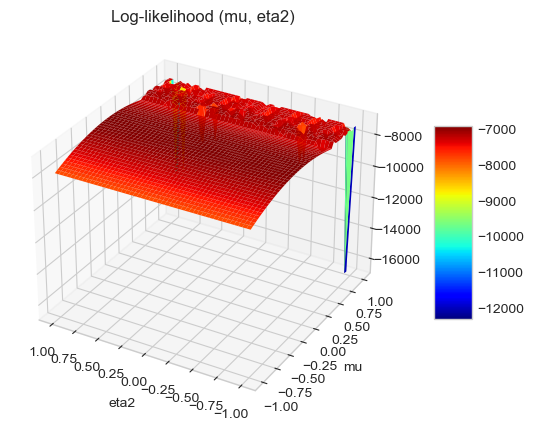

In [64]:
# plot figure in three dimensions
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.style.use('seaborn-whitegrid')


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1,projection='3d')

# Make data.
X, Y = np.meshgrid(eta3, mu)

# Plot the surface.
surf = ax.plot_surface(X, Y, log_lik, cmap=cm.jet)

# Customize the axis.
ax.set_xlabel(f'eta2')
ax.set_ylabel(f'mu')
ax.set_title(f'Log-likelihood (mu, eta2)')
ax.invert_xaxis()

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [75]:
theta0 = [0.1,0.1,0.1]
model = child_model()


# Estimate
nfxp_model, nfxp_results, pnames, theta_hat, Avar, converged = estimate.estimate(model, solver, data, theta0=theta0, twostep=1)

# Print 
print(f'Log-Likelihood:     {-nfxp_results.fun*samplesize:.4f}')
print(f'mu:                 {theta_hat[0]:.4f}')
print(f'eta2:               {theta_hat[1]:.4f}')
print(f'eta3:               {theta_hat[2]:.4f}')


print(nfxp_model, nfxp_results, pnames, theta_hat, Avar, converged)

Log-Likelihood:     -6970.7666
mu:                 0.1000
eta2:               0.1000
eta3:               0.1000
<mytest.child_model object at 0x7fb8dabf3460>      fun: 0.6970766600735233
    hess: array([[0.25196284, 0.91892298, 0.1837846 ],
       [0.91892298, 5.23771235, 1.04754247],
       [0.1837846 , 1.04754247, 0.20950849]])
     jac: array([0.05177919, 0.20704095, 0.04140819])
 message: 'A bad approximation caused failure to predict improvement.'
    nfev: 26
    nhev: 1
     nit: 26
    njev: 1
  status: 2
 success: False
       x: array([0.1, 0.1, 0.1]) ['mu', 'eta2', 'eta3'] [0.1 0.1 0.1] [[ 1.10200472e-03 -1.17341385e-02  5.76881487e-02]
 [-1.17389442e-02  1.07795258e+10 -5.38976288e+10]
 [ 5.77280227e-02 -5.38976288e+10  2.69488144e+11]] True


In [59]:
#res = optimize.minimize(ll,theta0, args = (model,solver,data, pnames), method = 'trust-ncg',jac = grad, hess = hes, tol = 1e-8)


NameError: name 'll' is not defined

In [57]:
theta0 = [1,1,1] + model.p.tolist()
res = optimize.minimize(estimate.ll,theta0, args = (model,solver,data,['mu','eta2', 'eta3']), method = 'trust-ncg',jac = estimate.grad, hess = estimate.hes, tol = 1e-8)
print(res.x)

h = estimate.hes(res.x, model, solver,data, pnames) # Hessian
print(h)
Avar = np.linalg.inv(h*samplesize) # Variance-Covariance matrix from information matrix equality



[1.     1.     1.     0.6252 0.3748]
[[1.40816357e-01 5.45326706e-01 1.09065341e+00 2.30316682e+17
  1.18497575e+17]
 [5.45326706e-01 5.89538697e+00 1.17907739e+01 2.07428909e+18
  1.19998863e+18]
 [1.09065341e+00 1.17907739e+01 2.35815479e+01 4.14857817e+18
  2.39997727e+18]
 [2.30316682e+17 2.07428909e+18 4.14857817e+18 1.03653372e+36
  5.44451747e+35]
 [1.18497575e+17 1.19998863e+18 2.39997727e+18 5.44451747e+35
  3.19088236e+35]]


LinAlgError: Singular matrix